# Projet MADI - Probabilistic Graphical Models


In this project we analyze the use of probabilistic graph models in order to express the conditional dependence structure amongst random variables.

In [1]:
%matplotlib inline
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import matplotlib.pyplot as plt
import pydotplus as dot
from IPython.display import SVG

In [2]:
%reload_ext autoreload
%autoreload 2
from projet_madi import *

## Graph Visualization

We begin by expressing the relationship between random variabes in the form of a Bayesian network, a graphical model which allows for modeling conditional dependence by way of Bayesian inference. Two acyclic graphs are presented below.

### BN 1

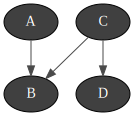

In [3]:
bn1=gum.fastBN("A->B<-C->D")
gnb.showBN(bn1)

### BN 2

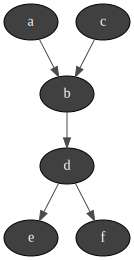

In [4]:
bn2=gum.BayesNet('SampleNet')

a, b, c, d, e, f = [ bn2.add(name, 2) for name in "abcdef" ]
for link in [(a,b),(c,b),(b,d),(d,e),(d,f)]:
    bn2.addArc(*link)

bn2.cpt(a).randomCPT()
bn2.cpt(b).randomCPT()
bn2.cpt(c).randomCPT()
bn2.cpt(d).randomCPT()
bn2.cpt(e).randomCPT()
bn2.cpt(f).randomCPT()

gnb.showBN(bn2)

We then extend these models into a factor graph, a graphical representation that allows us to explicitly represent the factorization of a probability distribution function. Such graphs are a generalization of constraint graphs where each factor represents a 0-1 constraint.

In [5]:
# initialize a factor graph based on the Bayes Net
fg1 = FactorGraph()
fg1.build(bn1)

### Factor Graph 1

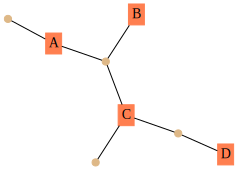

In [6]:
g1=dot.graph_from_dot_data(fg1.show())
SVG(g1.create_svg())

### Factor Graph 2

In [7]:
# initialize a factor graph based on the Bayes Net
fg2 = FactorGraph()
fg2.build(bn2)

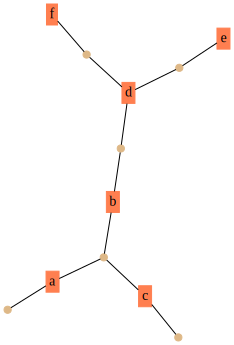

In [8]:
g2=dot.graph_from_dot_data(fg2.show())
SVG(g2.create_svg())

## Sum-Product Algorithm

The first algorithm implemented is the sum-product algorithm. It allows for calculating the marginal distribution of each random variable on the graph. On acyclic graphs this algorithm provides an exact computation of marginal distributions.

Inference on factor graph 1 results in the following posterior distributions at each node.

In [9]:
spi = TreeSumProductInference(fg1)
spi.makeInference() 

In [10]:
spi.posterior('A')  # A, B, C, D

(gum::Potential<double>@0x259bc80) <A:0> :: 0.28312 /<A:1> :: 0.71688

Inference on factor graph 2 results in the following posterior distributions at each node.

In [11]:
spi = TreeSumProductInference(fg2)
spi.makeInference() 

In [12]:
spi.posterior('b')  # a, b, c, d, e, f

(gum::Potential<double>@0x2a05200) <b:0> :: 0.641822 /<b:1> :: 0.358178

## Max-Product Algorithm

The next algorithm implemented is the max-product algorithm. It solves the problem of most probable explanation by computing the maximal configuration of the network.

In [13]:
mpi = TreeMaxProductInference(fg1)
mpi.makeInference()

In [14]:
mpi.argmax()

{'A': 1, 'B': 0, 'C': 1, 'D': 0}

In [15]:
mpi = TreeMaxProductInference(fg2)
mpi.makeInference()

In [16]:
mpi.argmax()

{'a': 1, 'b': 0, 'c': 0, 'd': 1, 'e': 1, 'f': 0}

## Max-Sum Algorithm

The max-sum product algorithm can also be used for computing the maximal configuration of a set of nodes but makes use of log-probabilties in order to speed up calculations on the graph.

In [17]:
msi = TreeMaxSumInference(fg1)
msi.makeInference()

In [18]:
msi.argmax()

{'A': 1, 'B': 0, 'C': 1, 'D': 0}

## Loopy Belief Propagation: Sum-Product

The next algorithm implemented is the loopy belief propagation algorithm for approximating implementation of the sum-product algorithm on cyclical graphs. This algorithm can provide approximate marginal values when working on acyclical graphs assuming proper convergence over interations.

### BN 3

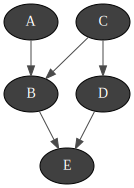

In [19]:
bn3=gum.fastBN("A->B<-C->D->E<-B")
gnb.showBN(bn3)

In [20]:
# initialize a factor graph based on the Bayes Net
fg3 = FactorGraph()
fg3.build(bn3)

### Factor Graph 3

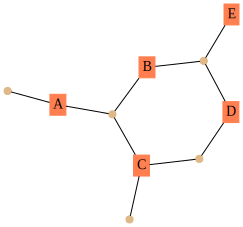

In [21]:
g3=dot.graph_from_dot_data(fg3.show())
SVG(g3.create_svg())

In [22]:
lbpspi = LBPSumProductInference(fg3)
lbpspi.makeInference()

In [23]:
lbpspi.posterior('C')

(gum::Potential<double>@0x25e05d0) <C:0> :: 0.999934 /<C:1> :: 6.57837e-05

## Comparison between LBP Sum-Product and Lazy Propagation

Our implmementation of Sum-Product Lazy Belief Propegation results in posterior distributions that generally resemble the configurations provided by exact inference using Lazy Propagation. Although when comparing the probabilites of the maximal configuration there is a significant difference in the probabilities for each random variable's configuration.

In [24]:
ie=gum.LazyPropagation(bn3)
ie.makeInference()

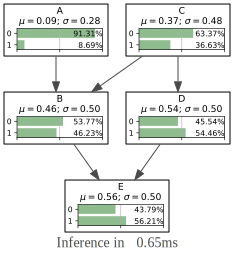

<C:0> :: 0.63372 /<C:1> :: 0.36628


In [25]:
gnb.showInference(bn3,size="18") # using LazyPropagation by default
print(ie.posterior('C'))


## Incorporating Hard Evidence

Evidence functionality was added to each type of inference allowing hard evidence to be added to a factor graph if passed as a dictionary of factors and boolean values (e.g. AddEvidence({A:1, E:0})). Take for example factor graph 2.

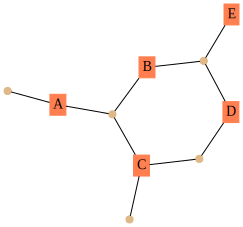

In [26]:
g3=dot.graph_from_dot_data(fg3.show())
SVG(g3.create_svg())

We can add evidence that 'f' takes value 1 and 'a' takes value 0 with the following.

In [27]:
lbpspi.addEvidence({'A':0, 'E':1})

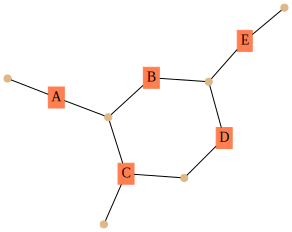

In [28]:
g3=dot.graph_from_dot_data(fg3.show())
SVG(g3.create_svg())

Unfortunately there was a bug in the code which I was not able to resolve prior to submission which prevented me from further analyzing the impact of evidence on the factor graph. 

In [ ]:
spi = TreeSumProductInference(fg2)
spi.makeInference() 

## Loopy Belief Propagation: Max-Product

A bug with my implementation of this algorithm is returning 'nan' making it impossible for the rest of the algorithm to convert the probabilities to log-probabilities so I cannot provide an analysis of the algorithm.

In [29]:
lbpmsi = LBPMaxSumInference(fg3)
lbpmsi.makeInference()

[(gum::Potential<double>@0x22e3700) <B:0|A:0|C:0> :: 0.223334 /<B:1|A:0|C:0> :: 0.0266656 /<B:0|A:1|C:0> :: 0.0267216 /<B:1|A:1|C:0> :: 0.223278 /<B:0|A:0|C:1> :: 0.00157323 /<B:1|A:0|C:1> :: 0.248427 /<B:0|A:1|C:1> :: 0.100307 /<B:1|A:1|C:1> :: 0.149693, (gum::Potential<double>@0x25f1cb0) <A:0> :: 1 /<A:1> :: 0]
[(gum::Potential<double>@0x22e3700) <B:0|A:0|C:0> :: nan /<B:1|A:0|C:0> :: nan /<B:0|A:1|C:0> :: nan /<B:1|A:1|C:0> :: nan /<B:0|A:0|C:1> :: nan /<B:1|A:0|C:1> :: nan /<B:0|A:1|C:1> :: nan /<B:1|A:1|C:1> :: nan, (gum::Potential<double>@0x2cef9a0) <E:0|D:0|B:0> :: 0.00406478 /<E:1|D:0|B:0> :: 0.245935 /<E:0|D:1|B:0> :: 0.14336 /<E:1|D:1|B:0> :: 0.10664 /<E:0|D:0|B:1> :: 0.175566 /<E:1|D:0|B:1> :: 0.0744338 /<E:0|D:1|B:1> :: 0.145321 /<E:1|D:1|B:1> :: 0.104679]
[(gum::Potential<double>@0x22e3700) <B:0|A:0|C:0> :: nan /<B:1|A:0|C:0> :: nan /<B:0|A:1|C:0> :: nan /<B:1|A:1|C:0> :: nan /<B:0|A:0|C:1> :: nan /<B:1|A:0|C:1> :: nan /<B:0|A:1|C:1> :: nan /<B:1|A:1|C:1> :: nan, (gum::Pot

/home/ebenge/Cours/MADI/projet_madi.py:697: RuntimeWarning: divide by zero encountered in log
  log_prob = [np.log(i) for i in np.array(cpt.tolist()).flatten()]
/home/ebenge/Cours/MADI/projet_madi.py:697: RuntimeWarning: invalid value encountered in log
  log_prob = [np.log(i) for i in np.array(cpt.tolist()).flatten()]
